# Кейс 2. Поиск аномалий в данных с дорожной инфраструктуры

Дорожно-транспортная инфраструктура включает в себя огромное количество станций,  которые фиксируют большое количество показателей, таких как: температура дорожного покрытия, скорость ветра, наличие тумана и другие условия на определенных дорожных участках. Зачастую оборудование (датчики) этих станций могут передавать некорректные данные на сервер в связи с выходом этих компонентов из строя. Для бригад, которые обслуживают данные дорожно-транспортные объекты очень важно своевременно определять выход из строя компонентов (датчиков) дорожных станций и проводить их ремонт и диагностику. 

Вам предстоит написать алгоритм машинного обучения, который сможет проанализировать пакеты данных станции за определенный промежуток и найти в этих данных аномалии. 

📌 Важно: в некоторых пакетах может содержаться значение null для определенного датчика. Такие значения также считаются аномальными, так как сигнализируют об ошибке оборудования

🏡 Данный кейс ведётся в Kaggle, там вы сможете скачать (https://www.kaggle.com/competitions/misis-hack/overview) датасет, отправить решение тестовых данных для выставления баллов.

### Описание данных: 
- configuration_item_id — ID дорожной станции
- ts — время отправки пакета данных станцией
- __insert_ts — время добавления пакета в бд
- keys -  массив с названием компонента
- values — и массив с его значением

In [1]:
import os
import ast
import pandas as pd
import numpy as np


curr_dir = "case_2"
if os.getcwd().split("/")[-1] != curr_dir:
    os.chdir(curr_dir)

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

print(train_df["keys"].unique(), test_df["keys"].unique(), sep="\n")

def convert_to_float(values):
    return [float(x) if x != 'null' else None for x in values]

def prepare_df(df):
    for k in ["keys", "values"]:
        df[k] = df[k].apply(lambda i: ast.literal_eval(i)[0])

    df['values'] = df['values'].apply(convert_to_float)
    df['ts'] = pd.to_datetime(df['ts'])
    
    expanded_df = pd.concat([pd.DataFrame([row['values']], columns=row['keys']) for _, row in df.iterrows()])
    expanded_df.reset_index(drop=True, inplace=True)
    df = pd.concat([df, expanded_df], axis=1)
    df.drop(columns=['keys', 'values', '__insert_ts'], inplace=True)
    df_sorted = df.sort_values(by=['configuration_item_id', 'ts']).reset_index(drop=True)
    
    return df_sorted

["[['meteo_layer_type', 'meteo_cloudiness', 'meteo_wind_velocity', 'meteo_humidity', 'meteo_t_underroad', 'meteo_freezing_point', 'meteo_wind_direction', 'meteo_dew_point', 'meteo_t_road', 'meteo_wind_gusts', 'meteo_t_air', 'meteo_air_pressure']]"]
["[['meteo_layer_type', 'meteo_cloudiness', 'meteo_wind_velocity', 'meteo_humidity', 'meteo_t_underroad', 'meteo_freezing_point', 'meteo_wind_direction', 'meteo_dew_point', 'meteo_t_road', 'meteo_wind_gusts', 'meteo_t_air', 'meteo_air_pressure']]"]


In [3]:
all_df = pd.concat([train_df, test_df])
all_df.reset_index(drop=True, inplace=True)
all_df = prepare_df(all_df)

all_features = [k for k in all_df.columns if k.startswith("meteo")]

In [4]:
all_df[all_df.duplicated()]

,id,configuration_item_id,ts,meteo_layer_type,meteo_cloudiness,meteo_wind_velocity,meteo_humidity,meteo_t_underroad,meteo_freezing_point,meteo_wind_direction,meteo_dew_point,meteo_t_road,meteo_wind_gusts,meteo_t_air,meteo_air_pressure


In [5]:
all_df.configuration_item_id.unique()

array([24445, 30928])

In [64]:
config_id = all_df.configuration_item_id.unique()[1]
config_df = all_df[all_df.configuration_item_id == config_id]
config_df.describe()

,id,configuration_item_id,meteo_layer_type,meteo_cloudiness,meteo_wind_velocity,meteo_humidity,meteo_t_underroad,meteo_freezing_point,meteo_wind_direction,meteo_dew_point,meteo_t_road,meteo_wind_gusts,meteo_t_air,meteo_air_pressure
count,1751.000000,1751.0,1625.000000,1751.000000,1751.000000,1751.000000,1751.000000,1625.0,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000
mean,875.000000,30928.0,1.238154,4.236436,2.508338,68.684580,24.663906,0.0,209.267847,10.239749,22.444660,4.776642,17.025814,736.582524
std,505.614478,0.0,0.649381,2.787330,1.716538,22.301462,10.514665,0.0,89.063192,6.774423,9.348167,2.864631,7.284565,3.867360
min,0.000000,30928.0,1.000000,2.000000,0.000000,13.300000,3.000000,0.0,0.000000,-7.100000,2.800000,0.000000,-1.300000,728.000000
25%,437.500000,30928.0,1.000000,2.000000,1.200000,49.500000,16.050000,0.0,163.000000,4.900000,14.500000,2.600000,11.400000,734.000000
50%,875.000000,30928.0,1.000000,3.000000,2.100000,71.400000,23.800000,0.0,217.000000,11.000000,21.800000,4.200000,16.700000,736.000000
75%,1312.500000,30928.0,1.000000,7.000000,3.400000,88.000000,31.600000,0.0,279.000000,16.400000,29.200000,6.200000,22.000000,739.000000
max,1750.000000,30928.0,5.000000,10.000000,10.300000,100.000000,49.900000,0.0,359.000000,22.900000,44.400000,18.200000,33.300000,748.000000


In [65]:
config_df.corr(numeric_only=True)

,id,configuration_item_id,meteo_layer_type,meteo_cloudiness,meteo_wind_velocity,meteo_humidity,meteo_t_underroad,meteo_freezing_point,meteo_wind_direction,meteo_dew_point,meteo_t_road,meteo_wind_gusts,meteo_t_air,meteo_air_pressure
id,1.000000,NaN,-0.169186,-0.142197,-0.250246,0.018509,0.603432,NaN,0.001782,0.713097,0.665375,-0.257670,0.640251,-0.529288
configuration_item_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
meteo_layer_type,-0.169186,NaN,1.000000,0.567111,0.092021,0.347798,-0.285861,NaN,-0.002422,0.079099,-0.280620,0.160709,-0.177742,-0.228212
meteo_cloudiness,-0.142197,NaN,0.567111,1.000000,0.063603,0.502819,-0.360659,NaN,-0.041078,0.149542,-0.346884,0.123277,-0.228957,-0.195934
meteo_wind_velocity,-0.250246,NaN,0.092021,0.063603,1.000000,-0.237157,0.027326,NaN,0.110241,-0.262115,-0.029401,0.954668,-0.062627,-0.041921
meteo_humidity,0.018509,NaN,0.347798,0.502819,-0.237157,1.000000,-0.602907,NaN,0.012915,0.368115,-0.533152,-0.236686,-0.452476,-0.265559
meteo_t_underroad,0.603432,NaN,-0.285861,-0.360659,0.027326,-0.602907,1.000000,NaN,-0.060122,0.452850,0.979978,0.034126,0.926252,-0.278665
meteo_freezing_point,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
meteo_wind_direction,0.001782,NaN,-0.002422,-0.041078,0.110241,0.012915,-0.060122,NaN,1.000000,-0.090041,-0.035902,0.119204,-0.099442,-0.019323
meteo_dew_point,0.713097,NaN,0.079099,0.149542,-0.262115,0.368115,0.452850,NaN,-0.090041,1.000000,0.505863,-0.250118,0.648808,-0.697195


In [67]:
from itertools import combinations

feature_combinations = list(combinations(all_features, 2))

correlation_results = []

for feat1, feat2 in feature_combinations:
    correlation = config_df[feat1].corr(config_df[feat2])
    correlation_results.append((feat1, feat2, correlation))

correlation_df = pd.DataFrame(correlation_results, columns=['Feature1', 'Feature2', 'Correlation']).sort_values(by='Correlation', ascending=False)
print(f"Feature correlation for {config_id} station:")
print(correlation_df[correlation_df.Correlation.abs() > 0.5])

Feature correlation for 30928 station:
               Feature1            Feature2  Correlation
41    meteo_t_underroad        meteo_t_road     0.979978
27  meteo_wind_velocity    meteo_wind_gusts     0.954668
43    meteo_t_underroad         meteo_t_air     0.926252
61         meteo_t_road         meteo_t_air     0.919594
58      meteo_dew_point         meteo_t_air     0.648808
0      meteo_layer_type    meteo_cloudiness     0.567111
56      meteo_dew_point        meteo_t_road     0.505863
12     meteo_cloudiness      meteo_humidity     0.502819
34       meteo_humidity        meteo_t_road    -0.533152
30       meteo_humidity   meteo_t_underroad    -0.602907
59      meteo_dew_point  meteo_air_pressure    -0.697195


In [9]:
def calculate_ema(data, alpha):
    """
    Calculate Exponential Moving Average (EMA) of a given data series.

    Parameters:
    - data (array-like): The input time series data.
    - alpha (float): Smoothing factor, between 0 and 1.

    Returns:
    - ema (ndarray): EMA values of the input data.
    """
    ema = np.zeros_like(data)
    ema[0] = next(item for item in data if not np.isnan(item))
    for i in range(1, len(data)):
        ema[i] = alpha * data[i] + (1 - alpha) * ema[i-1]
    return ema

def detect_anomalies_ema(time_series_data, alpha, n_std):
    """
    Detect anomalies in a time series using Exponential Moving Average (EMA).

    Anomalies are detected based on residuals (difference between data and EMA)
    exceeding a threshold number of standard deviations.

    Parameters:
    - time_series_data (array-like): The input time series data.
    - alpha (float): Smoothing factor for EMA, between 0 and 1.
    - n_std (float): Number of standard deviations for anomaly detection.

    Returns:
    - anomalies (ndarray of bool): Boolean array indicating anomalies.
    """
    ema = calculate_ema(time_series_data, alpha)
    residuals = time_series_data - ema
    std_dev = np.nanstd(residuals)  # standard deviation of residuals, ignoring NaNs
    
    anomalies = np.zeros_like(time_series_data, dtype=bool).astype(int)
    
    for i in range(len(time_series_data)):
        if np.isnan(time_series_data[i]) or np.abs(residuals[i]) > n_std * std_dev:
            anomalies[i] = 1
    
    return anomalies

alpha = 0.003  # smoothing factor
n_std = 3.44  # number of standard deviations for anomaly detection

all_anomalies = {}
config_ids = all_df.configuration_item_id.unique()

for config_id in config_ids:
    all_anomalies[config_id] = {}
    config_df = all_df[all_df.configuration_item_id == config_id]
    
    for feature in all_features:
        time_series_data = config_df[feature].values
        anomalies = detect_anomalies_ema(time_series_data, alpha, n_std)
        all_anomalies[config_id][feature] = anomalies

In [10]:
test_df = pd.read_csv("data/test.csv")
answers = []

for i, row in test_df.iterrows():
    config_id = row.configuration_item_id
    config_data = all_df[all_df.configuration_item_id == config_id]
    config_data.reset_index(drop=True, inplace=True)
    anomalies_ = list(zip(*all_anomalies[config_id].values()))
    id_in_anomalies = config_data[config_data.id == row.id].index[0]
    answers.append(list(anomalies_[id_in_anomalies]))
    
result_df = pd.DataFrame({"id": test_df.id.values.tolist(), 
                          "target": answers})
result_df.to_csv("case2.csv", index=False)

In [11]:
files = [pd.read_csv(name) for name in ["case_f.csv", "case2.csv"]]

for file in files:
    file["target"] = file["target"].apply(ast.literal_eval)

for i, (t1, t2) in enumerate(zip(files[0].target, files[1].target)):
    for f in range(len(t1)):
        if t1[f] != t2[f]:
            print(files[0].id.iloc[i], f, t1[f], t2[f])

# Визуализация

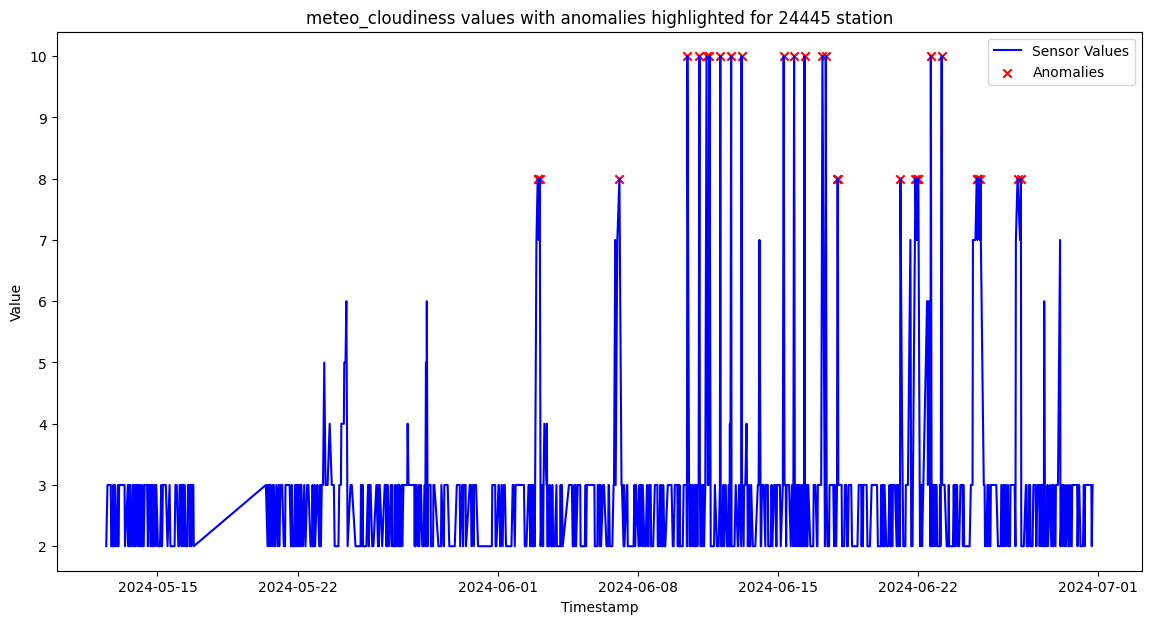

In [80]:
import matplotlib.pyplot as plt

config_id = config_ids[0]
config_df = all_df[all_df.configuration_item_id == config_id]

feature = all_features[1]
timestamps = config_df.ts
values = config_df[feature]
labels = all_anomalies[config_id][feature]
idx = np.where(labels == 1)[0]

data = pd.DataFrame({'timestamp': timestamps, 'value': values, 'label': labels})

plt.figure(figsize=(14, 7))
plt.plot(data['timestamp'], data['value'], label='Sensor Values', color='blue')
plt.scatter(data['timestamp'].iloc[idx], data['value'].iloc[idx], color='red', label='Anomalies', marker='x')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title(f'{feature} values with anomalies highlighted for {config_id} station')
plt.legend()
plt.show()